### **BOOSTING AND STACKING DEMO**

In [2]:
import pandas as pd
import requests
import io
import urllib3

# disable only the insecure request warning since we're knowingly skipping SSL verification
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv"

# fetch the file while skipping certificate verification, then load into pandas from bytes
resp = requests.get(url, verify=False)
resp.raise_for_status()
data = pd.read_csv(io.BytesIO(resp.content), sep=',')

In [3]:
data.shape

(10299, 562)

In [4]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [5]:
import numpy as np

# Mask to select float columns
float_columns = (data.dtypes == np.float64)

# Verify that the maximum of all float columns is 1.0
print( (data.loc[:,float_columns].max() == 1.0).all() )

# Verify that the minimum of all float columns is -1.0
print( (data.loc[:,float_columns].min() == -1.0).all() )

True
True


In [6]:
# integer encode the activities
# Split the data into train and test data sets. 
# Decide if the data will be stratified or not during the train/test split.

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Activity'] = le.fit_transform(data['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [7]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5])

In [8]:
# split the data into train and test data sets

from sklearn.model_selection import train_test_split

# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                 test_size=0.3, random_state=42)

In [9]:
X_train.shape, y_train.shape,X_test.shape,y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))

In [12]:
# Fit gradient boosted tree models with all parameters set to their defaults with the following tree numbers (n_estimators = [15, 25, 50, 100, 200, 400]) 
# and evaluate the accuracy on the test data for each of these models.
# Plot the accuracy as a function of estimator number.

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 25 trees


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 50 trees


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 100 trees


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 200 trees


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 400 trees


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


,error
n_trees,
15.0,0.051133
25.0,0.034304
50.0,0.019741
100.0,0.012945
200.0,0.011650
400.0,0.011650


(0.0, 440.00000000000006)

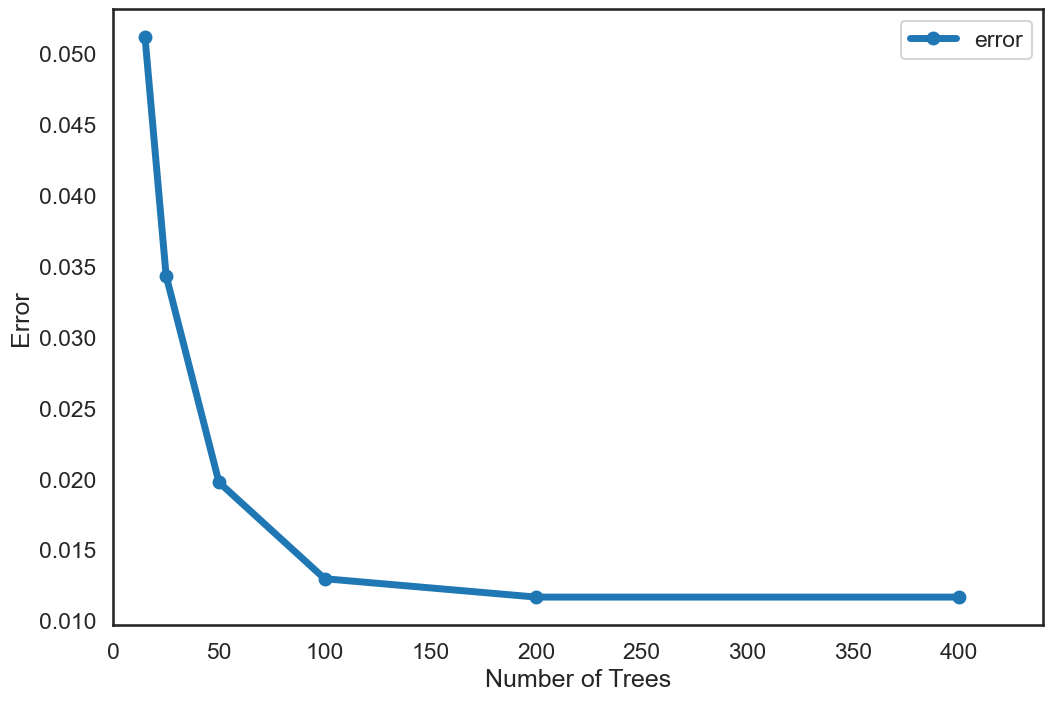

In [14]:
import seaborn as sns

# plot the result
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1)

*   Using a grid search with cross-validation, fit a new gradient boosted classifier with the same list of estimators above. Also try varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
*   Examine the parameters of the best fit model.
*   Calculate relevant error metrics on this model and examine the confusion matrix.


In [15]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [16]:
# The best model
GV_GBC.best_estimator_

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,400
,subsample,0.5
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [17]:
!pip install -U scikit-learn

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.97      0.97       555
           2       0.97      0.96      0.97       553
           3       1.00      1.00      1.00       540
           4       1.00      1.00      1.00       420
           5       0.99      0.99      0.99       425

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2.

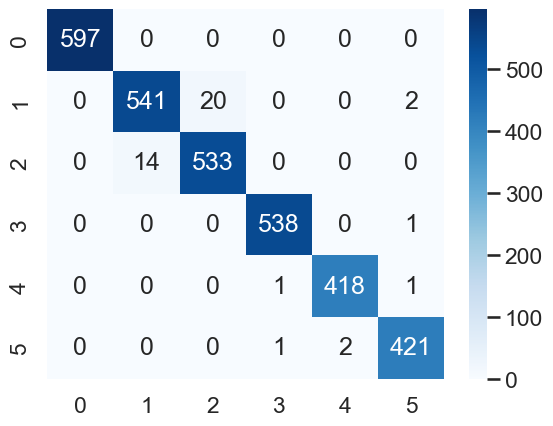

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

*   Create an AdaBoost model and fit it using grid search. Try a range of estimators between 100 and 200.
*   Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [21]:
# The best model
GV_ABC.best_estimator_

,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,100
,learning_rate,0.01
,algorithm,'deprecated'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [22]:
# The error metrics. 
# Note that the issues with class 1 and 2 appear to have become more problematic.
# AdaBoost is very sensitive to outliers, so that could be the problem here.


y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.00      0.00      0.00         0
           2       1.00      0.49      0.66      1109
           3       1.00      0.39      0.56      1384
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.54      3090
   macro avg       0.50      0.31      0.37      3090
weighted avg       1.00      0.54      0.68      3090



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

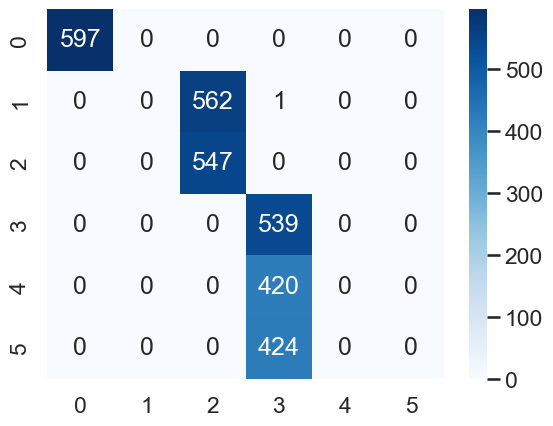

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

*   Fit a logistic regression model with regularization.
*   Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both).
*   Determine the error as before and compare the results to the appropriate gradient boosted model(s).
*   Plot the confusion matrix for the best model created in this set of exercises.

In [24]:
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.

In [25]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       0.95      0.96      0.95       558
           2       0.95      0.95      0.95       547
           3       1.00      0.99      0.99       544
           4       0.98      1.00      0.99       413
           5       1.00      0.98      0.99       430

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



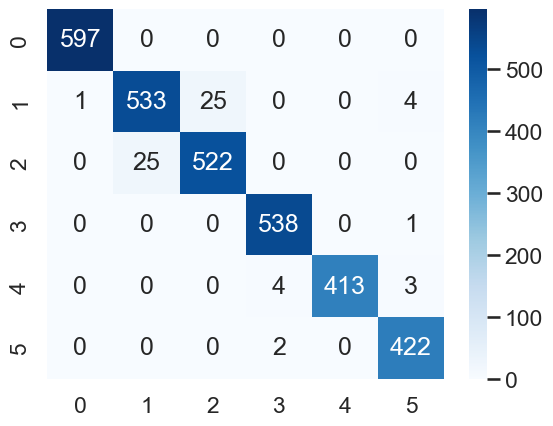

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

In [27]:
# the stacked model

from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Performance for the voting classifier should improve relative to either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder to try the simplest model first. In some cases, its performance will be good enough.

In [28]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.96      0.96       563
           2       0.96      0.97      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       420
           5       0.99      1.00      0.99       424

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



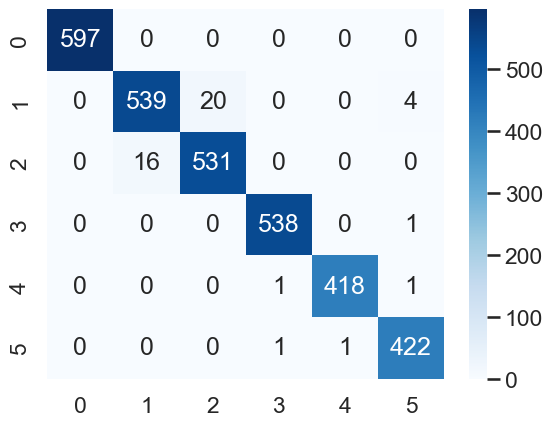

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()
#sns.set_context('talk')
#cm = confusion_matrix(y_test, y_pred)
#ax = sns.heatmap(cm, annot=True, fmt='d')